# Motor Imagery EEG-BCIs - 0 to Deep Learning with BCI-IV 2a dataset

@author: João Araújo ([LinkedIn](https://www.linkedin.com/in/joao-araujo-60470193/))

## 2 - Initial Modelling Ideas: channel-based, PCA and CSP
When trying to model EEG data for classification, we need to think what types of features contain discriminative information and what models can be chosen to make the best use of such information. Here, we will start by exploring initial feature engineering ideas one might have when dealing with EEG data, namely:

- Using a summary statistic of each channel data as our main set of features
- Deriving features from spatial filters using unsupervised methods (PCA)
- Deriving features from spatial filters using supervised methods (CSP)

We will also introduce the idea of model validation for EEG data - a process we must use to make sure our models do not overfit - while making sure we do not "leak" test data into the training including on the feature estimation stage. Let's start by setting up our initial variables and defining our main imports:

In [1]:
# Imports
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import clone

# Load our previous dataset
X = loadmat('BCI_IV_2a.mat')
# Define our variables of interest
M_res = X['M_res']
subj_labels = X['subj_labels']
class_labels = np.squeeze(X['class_labels'])

# Get our channel names list with the help of our description file
ch_names     = list(np.arange(1,23))
ch_names[0]  = 'Fz (1)'
ch_names[7]  = 'C3 (8)'
ch_names[9]  = 'Cz (10)'
ch_names[11] = 'C4 (12)'
ch_names[19] = 'Pz (20)'

# delete our loaded mat object
del X

### Channels as features
Here, we assume that EEG channels can individually hold the right information for classification as they are, without further transformations other than getting a summary statistic that captures the behaviour of each channel. For this example, let's say that summary statistic is variance:

In [2]:
# Calculate variance as the summary statistic of our signal to use as feature
X = np.var(M_res, axis = 2) 

<div style="text-align: justify">This leaves us with a more tabular dataset, with each channel being represented by one feature value - we eliminated the time-varying component of the dataset. Now we can think about fitting a model which will allow us to separate the 4 motor imagery conditions across subjects. 
</div>

<div style="text-align: justify">However, we need to test this model using a <strong>validation</strong> method. Ideally, we want this model to be able to generalize across different participants - so we need to account for inter-subject variance. For that, we should train our model using data from a few subjects and test the model on data from other subjects. As this is a small dataset (9 subjects), we can train the data on 8 subjects and test the model on the remaining subject and do this 9 times so the model gets tested on data from all participants. We can call it <strong>Leave-One-Participant-Out Cross-Validation</strong>:
</div>

In [3]:
## Function to perform One-Subject-Out Cross-Validation 

def validateSimpleModels(subj_labels,X,model):
    # Get our list of unique subjects to 
    unique_subjects = np.unique(subj_labels)
    
    # Initialize our list of test accuracy scores for every subject 
    test_scores = []
    
    # Perfrom cross-validation leaving always a different subject out
    for subject in unique_subjects:
        
        # Get training data and labels
        X_train = X[subj_labels != subject,:]
        y_train = class_labels[subj_labels != subject]
        
        # Fit model
        classifier = clone(model) # Clone model to reset it for every fold
        classifier.fit(X_train,y_train)
        
        # Get training accuracy
        train_fit = classifier.score(X_train,y_train)
        
        # Get test data (subject that we left out) and MI class labels
        X_test  = X[subj_labels == subject,:]
        y_test  = class_labels[subj_labels == subject]
        
        # Get accuracy
        test_fit = classifier.score(X_test,y_test)
        # Append score to our test scores
        test_scores.append(test_fit)

        print('Subject ' +str(subject)[:4]+' test acc: ' +str(test_fit)[:4]+ ' (train score: '+str(train_fit)[:4]+')')
    
    print('Average model accuracy: '+str(np.mean(test_scores))[:4])

<div style="text-align: justify">Now we can think of a model. We might hypothesize that a weighted combination of these channel variances will give us enough information to distinguish MI classes. Or we can hypothesize that our data is not linearly separable and we need to project this data into a non-linear space before separation. Let's test the two hypotheses and fit both a linear (logistic regression) and non-linear (SVM with radial-basis function) classifier on our features and see our results:</div>

In [4]:
# Quickly define some models
classifier_linear = LogisticRegression(random_state = 0,
                                penalty = 'l2',
                                C = 100,
                                max_iter = 5000,
                                multi_class = 'multinomial') 

classifier_svm = SVC(kernel = 'rbf', 
                     C = 100)

# See which one is best using our newly created function
validateSimpleModels(subj_labels,X,classifier_linear)
validateSimpleModels(subj_labels,X,classifier_svm)

Subject A01 test acc: 0.38 (train score: 0.42)
Subject A02 test acc: 0.29 (train score: 0.44)
Subject A03 test acc: 0.44 (train score: 0.41)
Subject A04 test acc: 0.33 (train score: 0.43)
Subject A05 test acc: 0.23 (train score: 0.44)
Subject A06 test acc: 0.27 (train score: 0.43)
Subject A07 test acc: 0.27 (train score: 0.43)
Subject A08 test acc: 0.42 (train score: 0.40)
Subject A09 test acc: 0.40 (train score: 0.40)
Average model accuracy: 0.34
Subject A01 test acc: 0.35 (train score: 0.55)
Subject A02 test acc: 0.24 (train score: 0.57)
Subject A03 test acc: 0.36 (train score: 0.53)
Subject A04 test acc: 0.27 (train score: 0.56)
Subject A05 test acc: 0.25 (train score: 0.57)
Subject A06 test acc: 0.26 (train score: 0.54)
Subject A07 test acc: 0.26 (train score: 0.57)
Subject A08 test acc: 0.36 (train score: 0.53)
Subject A09 test acc: 0.35 (train score: 0.53)
Average model accuracy: 0.30


<div style="text-align: justify">Analysing these accuracies, we can see that both models already work above chance level for most subjects. Interestingly we can see that the non-linear model, despite showing better training accuracies, does not show better test accuracies in a typical case of <em>overfitting<\em>.
</div>

### Introducing Spatial Filtering: PCA
<div style="text-align: justify">One next idea we can test concerns spatial filtering. Conceptually, we may think that creating new features by weighted combiniations of different channels may help in uncovering discriminant patterns of information. An unsupervised way of doing this is through PCA. When using PCA, we hypothesize that combinations of channels explaining different sources of uncorrelated variance will be also important features to distinguish MI classes. Let's implement our own custom PCA step-by-step to better understand what we are doing:</div>

In [5]:
# Imports
from numpy.linalg import eig

# Calculate PCA giving each subject the same weight (regardless of number of trials they have)
def myPCA(M_res,subj_labels):
    
    # Get our list of unique subjects 
    unique_subjects = np.unique(subj_labels)
    
    # Initialize our subject-weighted covariance
    Cov_subj = np.zeros((M_res.shape[1],M_res.shape[1]))
    
    # Iterate through every subject and get their channel covariance matrix
    for subject in unique_subjects:
        Data_subj = M_res[subj_labels == subject,:,:].swapaxes(1,2).reshape(-1,M_res.shape[1])
        Cov_subj += np.cov(Data_subj.T)
    
    # OPTIONAL: Compute the covariance without weighing the subjects
    #           Since this is a balanced dataset, the differences are
    #           minimal
    #Cov_subj = np.cov(M_res.swapaxes(1,2).reshape(-1,M_res.shape[1]).T)
    
    # Perform eigendecomposition to get the sorted eigenvalues and respective eigenvectors (PCs)
    evalues, evectors = eig(Cov_subj)
    
    # Return them
    return evalues,evectors
    
    

Once we apply PCA to our dataset, we can also evaluate the percentage of variance every single principal component explains and use that information to pick the PCs that will make it to our final feature space. As we will only select a fraction of these, you can also used this method to find a compressed representation of bigger EEG datasets.

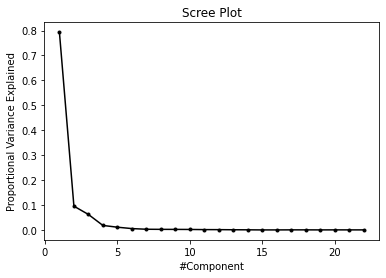

In [6]:
# Get our unique subject list
unique_subjects = np.unique(subj_labels)

# Get our PCs (covariance eigenvectors)
evalues, evectors = myPCA(M_res,subj_labels)

# Calculate explained variance for every component
var_exp = evalues / np.sum(evalues)

# Scree plot
plt.plot(np.arange(1,len(var_exp)+1),var_exp,'k')
plt.plot(np.arange(1,len(var_exp)+1),var_exp,'.k')
plt.xlabel('#Component')
plt.ylabel('Proportional Variance Explained')
plt.title('Scree Plot');

We can observe the following:
- The first component explains almost 80% of the total variance of the dataset;
- After the first 3 PC's, all other components explain similarly low variances.

In fact, let's see how much variance is explained on the first 3 components:

In [7]:
print(np.sum(var_exp[:3]))

0.9508848479854393


Our 3 most relevant components keep over 95% of the dataset variance! Let's take a look to the most important channels of these components:

In [8]:
# Get a table with the most important channel weights for each of the 3 most important components
best_evals_df = pd.DataFrame(evectors[:,:3].T**2,columns = ch_names, index = [1,2,3])
best_evals_df.index.name = 'Components'
# Add an heatmap effect to the table for easier visualization
best_evals_df.style.background_gradient(cmap ='gist_gray')

,Fz (1),2,3,4,5,6,7,C3 (8),9,Cz (10),11,C4 (12),13,14,15,16,17,18,19,Pz (20),21,22
Components,,,,,,,,,,,,,,,,,,,,,,
1,0.039609,0.036409,0.045973,0.050010,0.049010,0.043598,0.021333,0.037620,0.049619,0.056353,0.054552,0.048088,0.034153,0.038734,0.049767,0.056078,0.055404,0.050056,0.043924,0.051599,0.049286,0.038825
2,0.108346,0.050285,0.064181,0.083702,0.061411,0.047578,0.002653,0.004285,0.007671,0.011851,0.006781,0.002375,0.000670,0.016238,0.013510,0.016503,0.015253,0.016908,0.094402,0.096393,0.099325,0.179676
3,0.000015,0.045691,0.018167,0.000380,0.012750,0.046383,0.082211,0.111965,0.038367,0.001437,0.025376,0.124071,0.129773,0.122373,0.041155,0.001292,0.029279,0.122713,0.028250,0.000638,0.017515,0.000197


Looking at this table we can describe our components as:
- **Component 1** - A balanced average of most channels but generally stronger weights for central electrodes
- **Component 2** - Mostly a mix of frontal and parietal channels
- **Component 3** - Both left and right lateralized central channels

Let's integrate our feature estimation via PCA on our validation algorithm:

In [9]:
def validateSimpleModels_PCA(subj_labels,M_res,model,n_pcs):
    # Get our list of unique subjects to 
    unique_subjects = np.unique(subj_labels)
    
    # Initialize our list of test accuracy scores for every subject 
    test_scores = []
    
    # Perfrom cross-validation leaving always a different subject out
    for subject in unique_subjects:
        
        # Calculate our PC's from the training dataset
        evalues,evectors = myPCA(M_res[subj_labels != subject,:,:],subj_labels[subj_labels != subject])
        
        # Get our variance features from the PC-projected data (whole dataset)
        X = np.zeros((len(subj_labels),n_pcs))
        for i in range(M_res.shape[0]):
            X[i,:] = np.var(M_res[i,:,:].T @ evectors[:,:n_pcs],axis = 0)
        
        # Get our training data and MI class labels
        X_train = X[subj_labels != subject,:]
        y_train = class_labels[subj_labels != subject]
        
        # Fit our model to the training data
        classifier = clone(model)
        classifier.fit(X_train,y_train)
        
        # Get training accuracy (training fit)
        train_fit = classifier.score(X_train,y_train)
        
        # Get test data and labels
        X_test  = X[subj_labels == subject,:]
        y_test  = class_labels[subj_labels == subject]
        
        # Get test accuracy
        test_fit = classifier.score(X_test,y_test)
        # Append it to our test score list
        test_scores.append(test_fit)

        print('Subject ' +str(subject)[:4]+' test acc: ' +str(test_fit)[:4]+ ' (train score: '+str(train_fit)[:4]+')')
    
    print('Average model accuracy: '+str(np.mean(test_scores))[:4])

Let's assume a weighted sum of these spatial filters is indeed what we need for separating data. You can change the number of components to add to the model and see how it affects its classification performance.

In [10]:
# Define another linear classifier for our PCA-projected dataset
classifier_linear = LogisticRegression(random_state = 0,
                                solver = 'liblinear',
                                penalty = 'l2',
                                C = 1000,
                                max_iter = 20000) 

# Will it give better results than the channel-based classifier?
n_pcs = 22
validateSimpleModels_PCA(subj_labels,M_res,classifier_linear,n_pcs)

Subject A01 test acc: 0.38 (train score: 0.36)
Subject A02 test acc: 0.25 (train score: 0.37)
Subject A03 test acc: 0.36 (train score: 0.35)
Subject A04 test acc: 0.28 (train score: 0.36)
Subject A05 test acc: 0.27 (train score: 0.37)
Subject A06 test acc: 0.23 (train score: 0.35)
Subject A07 test acc: 0.28 (train score: 0.36)
Subject A08 test acc: 0.30 (train score: 0.34)
Subject A09 test acc: 0.25 (train score: 0.37)
Average model accuracy: 0.29


Unfortunately, PCA by itself did not improve our classification scores. In practice this means that building unsupervised spatial filters may not necessarily be helpful in a supervised learning task (at least by themselves). So what if we could build such filters in a supervised way?

### Introducing Spatial Filtering: CSP
Spatial filters can also be built in a supervised way, using svd or eigendecomposition methods similar to PCA - using methods like CSP. With CSP, we aim to estimate spatial filters that maximize the variance for an MI class while minimizing for another. This means the method is inherently useful for two-class classification problems but can also be extended for multiple classes using several different methods (check the MNE [code](https://github.com/mne-tools/mne-python/blob/main/mne/decoding/csp.py)). For the demonstration purposes of this notebook, however, we will choose two MI classes (right/left hand) to show how CSP works.

<div style="text-align: justify"> The way CSP is normally used is by choosing a bandpass (temporal) filter that will seggregate the specific frequencies we think are useful to separate these data. Then we estimate the spatial filters. Let's start by seggregating our 2 MI classes and filtering everything other than alpha and beta (SMR) bands.

In [11]:
# Imports for filter
from scipy.signal import butter, sosfiltfilt

# define bandpass filter
filter_order = 4
fs = 250
cutoff_freqs = np.array([8,25])
butter_sos = butter(N = filter_order, 
                    Wn = cutoff_freqs, 
                    btype = 'bandpass',
                    analog = False,
                    output = 'sos',
                    fs = fs)

subj_labels_2class = subj_labels[np.where(np.logical_or(class_labels == 1 , class_labels == 2))]
class_labels_2class = class_labels[np.where(np.logical_or(class_labels == 1 , class_labels == 2))]

M_res_2class = np.squeeze(M_res[np.where(np.logical_or(class_labels == 1 , class_labels == 2)),:,:])

for i in range(len(class_labels_2class)):
    M_res_2class[i,:,:] = sosfiltfilt(butter_sos, M_res_2class[i,:,:], axis = -1)
    

We then estimate CSPs by simultaneously diagonalizing the covariance matrices of both right/left MI classes. Our first eigenvectors will maximize the variance for class 1 and minimize the variance for class 2. The last eigenvectors will maximize the variance for class 2 and minimize for class 1. This estimation may look like this:

In [12]:
# Imports
from scipy.linalg import eigh

# Calculate CSP
def myCSP(M_res,subj_labels, class_labels):
    
    # Get our list of unique subjects to 
    unique_subjects = np.unique(subj_labels)
    
    # Initialize our subject-weighted covariance for class 1 (left hand)
    Cov_1 = np.zeros((M_res.shape[1],M_res.shape[1]))
    # Initialize our subject-weighted covariance for class 2 (right hand)
    Cov_2 = np.zeros((M_res.shape[1],M_res.shape[1]))
    
    # Get channel covariance matrix for both conditions           
    Cov_1 = np.cov(np.squeeze(M_res[class_labels == 1,:,:].swapaxes(1,2).reshape(-1,M_res.shape[1])).T)
    Cov_2 = np.cov(np.squeeze(M_res[class_labels == 2,:,:].swapaxes(1,2).reshape(-1,M_res.shape[1])).T)
    
    # Perform simultaneous diagonalization of both covariance matrices
    evalues, evectors = eigh(Cov_1, Cov_1 + Cov_2)
    # Sort vectors by value 
    evalues, evectors = evalues[np.argsort(evalues)], evectors[:,np.argsort(evalues)]
    
    # Return common spatial filters
    return evectors
    

We usually select a very small number of CSPs to add to the model. Let's see how the most discriminative filters for each class look like:

In [13]:
# Choose the number of filters to choose that maximize each class (n_filters = 2*m)
m = 1

# Get all possible CSPs
V = myCSP(M_res_2class,subj_labels_2class,class_labels_2class)

# Choose only the best m for each class
CSP = np.concatenate((V[:,:m], V[:,V.shape[1]-m:]),axis= 1)


# Get a table with the most important channel weights for each of the 3 most important components
best_evals_df = pd.DataFrame(CSP.T,columns = ch_names)
best_evals_df.index.name = 'CSPs'
# Add an heatmap effect to the table for easier visualization
best_evals_df.style.background_gradient(cmap ='seismic')

,Fz (1),2,3,4,5,6,7,C3 (8),9,Cz (10),11,C4 (12),13,14,15,16,17,18,19,Pz (20),21,22
CSPs,,,,,,,,,,,,,,,,,,,,,,
0,0.016514,-0.019027,0.034269,0.025976,0.036885,-0.093032,0.007868,-0.021807,0.091203,-0.067717,-0.291370,0.103689,-0.066289,-0.051078,0.004009,-0.018622,0.124376,0.330659,0.037850,0.072333,-0.271366,0.015994
1,-0.006211,-0.044547,-0.026386,0.085034,0.018323,-0.076827,0.159807,-0.264062,-0.251056,0.065950,0.075254,0.066666,-0.011456,0.311037,0.101538,-0.045784,-0.074915,-0.051794,-0.090834,0.001028,0.072617,-0.014629


From analysing the table we have:

- **CSP0**: Mostly dipoles at right parietal areas
- **CSP1** - Mostly dipoles at left central areas

Similarly to what we have done for PCA, let's integrate CSP into our validation pipeline:

In [14]:
def validateSimpleModels_CSP(subj_labels,M_res,class_labels,model,m):
    # Get our list of unique subjects to 
    unique_subjects = np.unique(subj_labels)
    
    # Initialize our list of test accuracy scores for every subject 
    test_scores = []
    
    # Perfrom cross-validation leaving always a different subject out
    for subject in unique_subjects:
        
        # Calculate our spatial filters from the training dataset
        V = myCSP(M_res[subj_labels != subject,:,:],subj_labels[subj_labels != subject],class_labels_2class[subj_labels != subject])
        
        # Choose only the best m for each class
        CSP = np.concatenate((V[:,:m], V[:,V.shape[1]-m:]),axis= 1)
        
        # Get our variance features from the CSP-projected data
        X = np.zeros((len(subj_labels),2*m))
        for i in range(M_res.shape[0]):
            X[i,:] = np.var(M_res[i,:,:].T @ CSP,axis = 0) / np.sum(np.var(M_res[i,:,:].T @ CSP,axis = 0))
        
        # Get our training data and MI class labels
        X_train = X[subj_labels != subject,:]
        y_train = class_labels[subj_labels != subject]
        
        # Fit our model to the training data
        classifier = clone(model)
        classifier.fit(X_train,y_train)
        
        # Get training accuracy (training fit)
        train_fit = classifier.score(X_train,y_train)
        
        # Get test data and labels
        X_test  = X[subj_labels == subject,:]
        y_test  = class_labels[subj_labels == subject]
        
        # Get test accuracy
        test_fit = classifier.score(X_test,y_test)
        # Append it to our test score list
        test_scores.append(test_fit)

        print('Subject ' +str(subject)[:4]+' test acc: ' +str(test_fit)[:4]+ ' (train score: '+str(train_fit)[:4]+')')
    
    print('Average model accuracy: '+str(np.mean(test_scores))[:4])

And now lets see how do we do using a linear model. Remember since we are working with only 2 classes for this demonstration, chance level is at 0.5. You can change the number of filters and see how the classification changes too:

In [15]:
# Choose the number of filters that maximize the variance of each class to use
m = 3

classifier_linear = LogisticRegression(random_state = 0,
                                solver = 'liblinear',
                                penalty = 'l2',
                                C = 100) 

validateSimpleModels_CSP(subj_labels_2class,M_res_2class,class_labels_2class,classifier_linear,m)

Subject A01 test acc: 0.70 (train score: 0.69)
Subject A02 test acc: 0.52 (train score: 0.71)
Subject A03 test acc: 0.87 (train score: 0.66)
Subject A04 test acc: 0.69 (train score: 0.69)
Subject A05 test acc: 0.53 (train score: 0.71)
Subject A06 test acc: 0.52 (train score: 0.69)
Subject A07 test acc: 0.60 (train score: 0.70)
Subject A08 test acc: 0.93 (train score: 0.64)
Subject A09 test acc: 0.70 (train score: 0.72)
Average model accuracy: 0.67


### Next up: Deep Learning
While we are getting accuracies that are better than chance we are still far away from state-of-art performances. In the next notebook, we will explore how we can use more advanced methods to test more complex and plausible ideas regarding useful information extraction from our EEG data.